# Organ Transplantation Example

In [1]:
%load_ext autoreload
%autoreload 2

import copy

import matplotlib.image as mpl_img
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

from htc.context.settings_context import settings_context
from htc.cpp import map_label_image
from htc.models.common.torch_helpers import move_batch_gpu
from htc.models.common.transforms import HTCTransformation
from htc.models.image.DatasetImage import DatasetImage
from htc.settings_seg import settings_seg
from htc.tivita.DataPath import DataPath
from htc.utils.Config import Config

In [2]:
path1 = DataPath.from_image_name("P058#2020_05_13_17_26_08")
path2 = DataPath.from_image_name("P049#2020_02_11_19_15_08")

## Clean Images

In [3]:
label_mapping = settings_seg.label_mapping
label_mapping.label_colors = settings_seg.label_colors_paper
config = Config({"label_mapping": label_mapping, "input/n_channels": 3})
dataset = DatasetImage([path1, path2], train=False, config=config)

for i in range(len(dataset)):
    sample = dataset[i]
    mpl_img.imsave(
        settings_context.paper_dir / f"ot_example_seg{i}.png",
        map_label_image(sample["labels"].numpy(), label_mapping),
    )

    mpl_img.imsave(settings_context.paper_dir / f"ot_example_rgb{i}.png", sample["features"].numpy())

## Transplanted Images

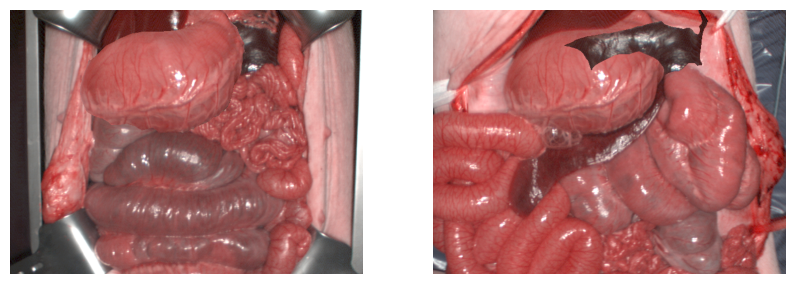

In [4]:
torch.manual_seed(14)
config = Config(
    {
        "input/n_channels": 3,
        "input/transforms_gpu": [
            {
                "class": "htc.context.context_transforms>OrganTransplantation",
                "p": 1,
            }
        ],
        "label_mapping": label_mapping,
    }
)
dataset = DatasetImage([path1, path2], train=False, config=config)
dataloader = DataLoader(dataset, batch_size=len(dataset))

batch = next(iter(dataloader))
batch_copy = copy.deepcopy(batch)

batch_gpu = move_batch_gpu(batch)
aug = HTCTransformation.parse_transforms(config["input/transforms_gpu"], config=config)
batch_gpu = HTCTransformation.apply_valid_transforms(batch_gpu, aug)

for i in range(len(dataset)):
    mpl_img.imsave(
        settings_context.paper_dir / f"ot_example_transformed_seg{i}.png",
        map_label_image(batch_gpu["labels"][i].cpu().numpy(), label_mapping),
    )

    mpl_img.imsave(
        settings_context.paper_dir / f"ot_example_transformed_rgb{i}.png", batch_gpu["features"][i].cpu().numpy()
    )

fig, ax = plt.subplots(ncols=len(dataset), figsize=(10, 5))
for i in range(len(dataset)):
    ax[i].imshow(batch_gpu["features"][i].cpu())
    ax[i].axis("off")

In [5]:
selected_organ = {
    0: 7,
    1: 6,
}

for i in range(len(dataset)):
    height = batch["features"][i].size(0)
    width = batch["features"][i].size(1)

    rgb = torch.zeros(height, width, 4)
    seg = torch.zeros(height, width, 4)
    features = torch.cat([batch["features"][i], torch.ones(height, width, 1)], dim=-1)
    labels = map_label_image(batch["labels"][i], label_mapping)

    label_mask = batch["labels"][i] == selected_organ[i]
    rgb[label_mask] = features[label_mask]
    seg[label_mask] = labels[label_mask]

    mpl_img.imsave(settings_context.paper_dir / f"ot_example_transplanted_rgb{i}.png", rgb.numpy())
    mpl_img.imsave(settings_context.paper_dir / f"ot_example_transplanted_seg{i}.png", seg.numpy())